# Problem statement

Tackle the Titanic dataset. A great place to start is on [Kaggle](https://www.kaggle.com/c/titanic/overview).

Following the Machine Learning project checklist from Hands-On Machine Learning refference, starting with:
## 1. Frame the problem and look at the big picture.

By considering this overview about the problme:


*The sinking of the Titanic is one of the most infamous shipwrecks in history.

*On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.*

*While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.*

*In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).*

***Goal**<br>
It is your job to predict if a passenger survived the sinking of the Titanic or not.
For each in the test set, you must predict a 0 or 1 value for the variable.*

***Metric**<br>
Your score is the percentage of passengers you correctly predict. This is known as accuracy.*


Well, it is clearly a typical *supervised* task, and it is also a typical *classification* task, more precisely, it is a *binary classification* task.

## 2. Get the data.

import the required modules:

In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore') # disable warnnings

fetch the data and split it:

In [72]:
X = pd.read_csv("./train.csv")
X.drop("PassengerId", axis=1, inplace=True)
y = X["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
6,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
718,0,3,"McEvoy, Mr. Michael",male,NaN,0,0,36568,15.5000,NaN,Q
685,0,2,"Laroche, Mr. Joseph Philippe Lemercier",male,25.0,1,2,SC/Paris 2123,41.5792,NaN,C
73,0,3,"Chronopoulos, Mr. Apostolos",male,26.0,1,0,2680,14.4542,NaN,C
882,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S


Refer to the data dictionary at the website of the problem to learn more about each attribute.

## 3. Explore the data to gain insights.

In [73]:
X_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,596.000000,596.000000,478.000000,596.000000,596.000000,596.000000
mean,0.372483,2.337248,29.525983,0.577181,0.374161,31.912786
std,0.483872,0.823207,14.457437,1.229504,0.807072,51.480961
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.250000,0.000000,0.000000,7.925000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.275000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


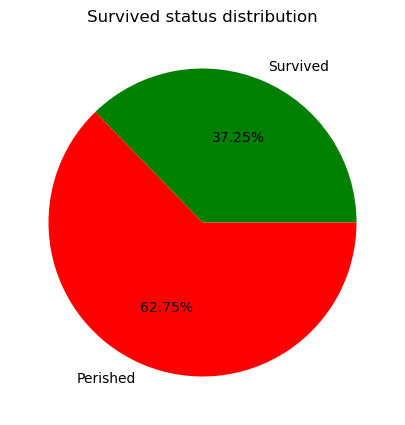

In [120]:
plt.figure(figsize=(10, 5))
plt.pie(
    [len(survived_ages), len(perished_ages)], labels=["Survived", "Perished"],
    colors=["green", "red"],  autopct='%1.2f%%'
    )
plt.title("Survived status distribution")
plt.show()

In [124]:
spearmanr(X_train["Survived"], X_train["Pclass"])

SignificanceResult(statistic=-0.3166473230319243, pvalue=2.3985194151745787e-15)

There is a negative moderate relationship between *Pclass*  and *Survived* status, so that, the passengers with higher class numbers have a lower likelihood of survival.

In [28]:
X_train.describe(include=["object"])

,Name,Sex,Ticket,Cabin,Embarked
count,596,596,596,134,595
unique,596,2,480,104,3
top,"McCarthy, Mr. Timothy J",male,CA. 2343,C23 C25 C27,S
freq,1,390,7,4,437


The average passenger *Age* is 30, ranging from 5-month-old babies to 80 years old, and most of them were men (390 out of 596).

The majority of passengers were from the third class, since the 50th and 75th percentiles are 3.

The mean number of *siblings/spouses* aboard the Titanic was 0.57, indicating that most passengers were found with zero or one sibling/spouse.

For *Parch*, the mean was 0.37, indicating that most passengers had fewer than one parent or child on board, as both the 50th and 75th percentiles are 0.

The average *Fare* was 31.9 with a high variation of 51 (standard deviation).

There are 596 unique passenger names, indicating there are no redundant rows.

The *Cabin* column has significant missing data (only 134 out of 596 are recorded).

Finally, *Embarked* has three unique values (C, Q, S), with 'S' (Southampton) being the most common embarkation point (437 out of 595).

## 4. Prepare the data to better expose the underlying data patterns to Machine Learning algorithms.

In [135]:
X.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

I'll impute the mean *Age* for nan values, and for *Embarked* the mode values (i.e. S).
Well, for *Cabin* I'll discard it from the analysis, as well as for *Name*, *Ticket*.

Moving forward to built a `pipeline` system.

In [221]:
num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Sex", "Embarked"]

num_pipeline = Pipeline([
        ("imp", SimpleImputer(strategy="mean")),
        ("zscaller", StandardScaler())
    ])

cat_pipeline = Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("enc", OneHotEncoder())
    ])

pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat_sex_emb", cat_pipeline, ["Sex", "Embarked"]),
    ("pclass", "passthrough", ["Pclass"])
])


In [229]:
X_prepared = pipeline.fit_transform(X)

/home/amq/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## 5. Explore many different models and shortlist the best ones.

In [277]:
knn = KNeighborsClassifier()
np.mean(cross_val_score(knn, X_prepared, y, cv=10, scoring="accuracy"))

0.8047690387016229

not bad!

Lets try some other models.

In [283]:
sgd_clf = SGDClassifier()
np.mean(cross_val_score(sgd_clf, X_prepared, y, cv=10, scoring="accuracy"))

0.7294506866416979

In [361]:
svc_clf = SVC?
np.mean(cross_val_score(svc_clf, X_prepared, y, cv=10, scoring="accuracy"))

0.8271785268414481

In [285]:
naive_clf = BernoulliNB()
np.mean(cross_val_score(naive_clf, X_prepared, y, cv=10, scoring="accuracy"))

0.7822471910112359

In [286]:
forest_clf = RandomForestClassifier()
np.mean(cross_val_score(forest_clf, X_prepared, y, cv=10, scoring="accuracy"))

0.8148813982521848

In [287]:
adab_clf = AdaBoostClassifier()
np.mean(cross_val_score(adab_clf, X_prepared, y, cv=10, scoring="accuracy"))

0.8070037453183521

In [288]:
gb_clf = GradientBoostingClassifier()
np.mean(cross_val_score(gb_clf, X_prepared, y, cv=10, scoring="accuracy"))

0.8328089887640449

In [262]:
def get_wrong_clf(x, y_true):
    idx = []
    for i in range(len(y_true)):
        if x[i] != y_true[i]:
            idx.append(i)
    return idx

All of GradientBoosting, AdaBoost, RandomForest, SVC, and KNN performing well.

## 6. Fine-tune your models and combine them into a great solution.

Starting with KNN:

In [302]:
param_grid = [{
        'weights': ["uniform", "distance"], 
        'n_neighbors': range(1, 101)
    }]

In [307]:
knn_clf = KNeighborsClassifier(n_jobs=-1)
grid_search_knn = GridSearchCV(knn_clf, param_grid=param_grid, cv=10, n_jobs=-1, scoring="accuracy")

In [308]:
grid_search_knn.fit(X_prepared, y)
grid_search_knn.best_params_

{'n_neighbors': 25, 'weights': 'uniform'}

In [309]:
grid_search_knn.best_score_

0.8148689138576779

In [310]:
knn_clf = KNeighborsClassifier(**grid_search_knn.best_params_)

In [431]:
param_grid_svc = [
    {
        "kernel": ['rbf', 'poly', 'sigmoid'],
        "degree": [3, 4, 5],
        "C": [1, 3, 5],
        "shrinking": [True, False],
        "coef0": [0.05, 0.07, 0.09]
    }
]

In [432]:
grid_search_svc = GridSearchCV(SVC(), param_grid=param_grid_svc, cv=10, n_jobs=-1, scoring="accuracy")
grid_search_svc.fit(X_prepared, y)
(grid_search_svc.best_params_), (grid_search_svc.best_score_)

({'C': 1, 'coef0': 0.07, 'degree': 3, 'kernel': 'poly', 'shrinking': True},
 0.8339076154806492)

In [433]:
svc_clf = SVC(**grid_search_svc.best_params_)

In [453]:
param_grid_forest = [
    {
        "criterion": ["gini", "entropy", "log_loss"],
        "n_estimators": range(50, 201, 10),
        "max_leaf_nodes": range(30, 41, 1), 
        "bootstrap": [True, False]
    }
]

grid_search_forest = GridSearchCV(RandomForestClassifier(), param_grid=param_grid_forest, cv=10, n_jobs=-1, scoring="accuracy")
grid_search_forest.fit(X_prepared, y)
(grid_search_forest.best_params_), (grid_search_forest.best_score_)

({'bootstrap': False,
  'criterion': 'gini',
  'max_leaf_nodes': 36,
  'n_estimators': 70},
 0.8384019975031212)

In [459]:
forest_clf = RandomForestClassifier(**grid_search_forest.best_params_)

In [483]:
param_grid_adaboost = [
    {
        "estimator": [forest_clf, svc_clf, knn_clf],
        "n_estimators": range(1, 50),
        "algorithm" : ['SAMME', 'SAMME.R'],
        "learning_rate":[0.5, 0.51, 0.55, 0.54]
    }
]

grid_search_adaboost = GridSearchCV(AdaBoostClassifier(), param_grid=param_grid_adaboost, cv=10, n_jobs=-1, scoring="accuracy")
grid_search_adaboost.fit(X_prepared, y)
(grid_search_adaboost.best_params_), (grid_search_adaboost.best_score_)

({'algorithm': 'SAMME.R',
  'estimator': RandomForestClassifier(bootstrap=False, max_leaf_nodes=36, n_estimators=70),
  'learning_rate': 0.5,
  'n_estimators': 5},
 0.8395255930087389)

In [486]:
adaboost_clf = AdaBoostClassifier(**(grid_search_adaboost.best_params_))

In [513]:
param_grid_gradboost = [{
    "loss": ["log_loss", "exponential"],
    "learning_rate": [0.3, 0.4, 0.5, 0.6],
    "n_estimators": range(25, 36, 1),
    "init": [adaboost_clf, forest_clf, svc_clf],
    "max_features" : ['sqrt', 'log2', None],
    "warm_start": [True, False]
}]

grid_search_gradboost = GridSearchCV(GradientBoostingClassifier(), param_grid=param_grid_gradboost, cv=10, n_jobs=-1, scoring="accuracy")
grid_search_gradboost.fit(X_prepared, y)
(grid_search_gradboost.best_params_), (grid_search_gradboost.best_score_)

({'init': RandomForestClassifier(bootstrap=False, max_leaf_nodes=36, n_estimators=70),
  'learning_rate': 0.4,
  'loss': 'exponential',
  'max_features': None,
  'n_estimators': 32,
  'warm_start': True},
 0.8440324594257179)

In [515]:
gradboost_clf = GradientBoostingClassifier(**grid_search_gradboost.best_params_)

In [521]:
gradboost_clf.fit(X_prepared, y)
adaboost_clf.fit(X_prepared, y)
forest_clf.fit(X_prepared, y)
svc_clf.fit(X_prepared, y)
knn_clf.fit(X_prepared, y)

KNeighborsClassifier(n_neighbors=25)

Let's define a function that makes a weighted voting predictions:

In [562]:
def weighted_voting_predict(X):
    X_predicts = np.empty(X.shape[0])
    for i, x in enumerate(X):
        surv, perished = (0, 0)
        if gradboost_clf.predict([x]) == 1:
            surv += grid_search_gradboost.best_score_
        else:
            perished += grid_search_gradboost.best_score_
            
        if adaboost_clf.predict([x]) == 1:
            surv += grid_search_adaboost.best_score_
        else:
            perished += grid_search_adaboost.best_score_
            
        if forest_clf.predict([x]) == 1:
            surv += grid_search_forest.best_score_
        else:
            perished += grid_search_forest.best_score_
            
        if svc_clf.predict([x]) == 1:
            surv += grid_search_svc.best_score_
        else:
            perished += grid_search_svc.best_score_
        
        if knn_clf.predict([x]) == 1:
            surv += grid_search_knn.best_score_
        else:
            perished += grid_search_knn.best_score_
            
        if surv > perished:
            X_predicts[i] = 1
        else:
            X_predicts[i] = 0
            
    return X_predicts.astype(np.int8)

In [557]:
accuracy_score(y_true=y, y_pred=weighted_voting_predict(X_prepared))

0.8900112233445566

Now, this is much better.

## 7. Launch, monitor, and maintain your system.

Let's now load the test dataset, and call the `weighted_voting_predict` function to make predictions:

In [563]:
y_test_ = pd.read_csv("test.csv")
submit = y_test_[["PassengerId"]]
y_prepared = pipeline.fit_transform(y_test_)
submit["Survived"] = weighted_voting_predict(y_prepared)
submit.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [564]:
submit.to_csv("submit1.csv", index=None)

This will gain a score of `0.78708` on Kaggle :)